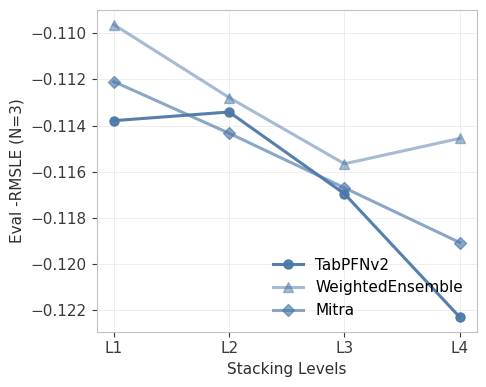

In [ ]:
# ========================== User Input Area ==========================
# Paste the entire output table from predictor.leaderboard (as printed text) between the triple quotes below.
table_str = """
"""

# ========================== Plot Config (easy to tune) ==========================
import matplotlib.pyplot as plt

# Style
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#C0C0C0",
    "axes.linewidth": 0.8,
    "axes.labelcolor": "#2E2E2E",
    "xtick.color": "#3A3A3A",
    "ytick.color": "#3A3A3A",
    "grid.color": "#D7D7D7",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.5,
    "font.size": 11,
    "font.family": "DejaVu Sans",
})

# Palette
c_front = "#4C78A8"   # desaturated blue
c_other = "#A9A9A9"   # neutral grey
c_line  = "#4C78A8"

# Figure and line aesthetics
CONFIG = {
    "figsize": (5, 4),
    "x_ticks": [1, 2, 3, 4],
    "x_tick_labels": ["L1", "L2", "L3", "L4"],
    "x_label": "Stacking Levels",
    "y_label": "Eval -RMSLE (N=3)",
    "y_label_improvement": "score vs L1 (absolute)",  # used when use_improvement=True
    "y_metric": "score_val",  # "score_test" or "score_val"
    "title": "Model family performance vs stacking depth",
    "set_title": False,
    "legend_loc": "lower right",
    "legend_offset": None,  # e.g., (1.02, 0.5) in axes fraction to nudge legend; None uses loc only
    "xlim": None,  # axis range: set to a tuple (min, max) to lock range; None = default
    "ylim": None,  # e.g., ylim=(-0.005, 0.010)
    "use_improvement": False,  # If True, plot  vs L1 per family so all curves start at 0
    "enabled_families": ["TabPFNv2", "WeightedEnsemble", "Mitra"],  # e.g., ["TabPFNv2", "WeightedEnsemble"]; None = plot all in family_order
    "y_log_scale": False,  # If True, set y-axis to log scale (requires positive y)
    "y_log_zero_offset": None,  # e.g., 1e-6 to replace non-positive y when log scale is enabled
    "linewidth": 2.2,
    "markersize": 6.5,
    # Different alphas per curve (tunable globally)
    "family_alphas": {
        "TabPFNv2": 0.95,
        "TabM": 0.80,
        "Mitra": 0.65,
        "WeightedEnsemble": 0.50,
    },
    # Linestyles per curve (tunable)
    "family_linestyles": {
        "TabPFNv2": "-",
        "TabM": "-",
        "WeightedEnsemble": "-",
        "Mitra": "-",
    },
    # Markers per curve (tunable)
    "family_markers": {
        "TabPFNv2": "o",
        "TabM": "s",
        "WeightedEnsemble": "^",
        "Mitra": "D",
    },
    # Colors per curve (can all share the same hue if desired)
    "family_colors": {
        "TabPFNv2": c_line,
        "TabM": c_line,
        "WeightedEnsemble": c_line,
        "Mitra": c_line,
    },
    # Order to draw curves
    "family_order": ["TabPFNv2", "TabM", "WeightedEnsemble", "Mitra"],
}

# ========================== Code ==========================
import re
import io
import pandas as pd

def parse_table_to_df(table_text: str) -> pd.DataFrame:
    """
    Robustly parse the printed table text into a DataFrame with
    columns: ['model', 'score_test', 'score_val', 'stack_level'].

    Assumptions:
    - Each data row starts with an integer index.
    - 'model' is the next token after the index.
    - 'score_test' and 'score_val' are the first two numeric tokens after 'model'.
    - 'stack_level' is the 3rd token from the line end (as per AutoGluon printout).
    """
    if not table_text or not table_text.strip():
        return pd.DataFrame(columns=["model", "score_test", "score_val", "stack_level"])

    lines = [ln.rstrip("\n") for ln in table_text.splitlines()]
    # Remove code fences or empty lines
    lines = [ln for ln in lines if ln.strip() and not ln.strip().startswith("```")]

    records = []
    for ln in lines:
        if not re.match(r"^\s*\d+\b", ln):
            continue
        tokens = re.split(r"\s+", ln.strip())
        if len(tokens) < 5:
            continue
        # tokens: [index, model, score_test, score_val, ... , stack_level, can_infer, fit_order]
        try:
            model = tokens[1]
            # Find first two float tokens after the model (score_test, score_val)
            floats = []
            for t in tokens[2:]:
                try:
                    floats.append(float(t))
                    if len(floats) == 2:
                        break
                except Exception:
                    continue
            if len(floats) == 0:
                continue
            score_test = floats[0]
            score_val = floats[1] if len(floats) > 1 else floats[0]

            # stack_level typically at tokens[-3]
            stack_level = None
            try:
                stack_level = int(tokens[-3])
            except Exception:
                # Fallback: scan from end to find a small non-negative int (0..10)
                for t in reversed(tokens):
                    if re.fullmatch(r"-?\d+", t):
                        v = int(t)
                        if 0 <= v <= 10:
                            stack_level = v
                            break
            if stack_level is None:
                continue

            records.append((model, score_test, score_val, stack_level))
        except Exception:
            continue

    return pd.DataFrame(records, columns=["model", "score_test", "score_val", "stack_level"])


def family_from_model_name(name: str) -> str | None:
    if name.startswith("TabPFNv2"):
        return "TabPFNv2"
    if name.startswith("TabM"):
        return "TabM"
    if name.startswith("Mitra"):
        return "Mitra"
    if name.startswith("WeightedEnsemble"):
        return "WeightedEnsemble"
    return None


def prepare_family_level_means(df: pd.DataFrame, value_col: str) -> pd.DataFrame:
    """
    - Assign family by model name prefix.
    - Create plot_level = stack_level for all, except WeightedEnsemble where plot_level = stack_level - 1.
    - Keep only plot_level in [1, 4].
    - Average the selected value column across models within each (family, plot_level).
    Returns columns: ['family','plot_level','y'] where 'y' is the averaged value.
    """
    df = df.copy()
    df["family"] = df["model"].apply(family_from_model_name)
    df = df[df["family"].notna()]

    df["plot_level"] = df["stack_level"]
    mask_we = df["family"] == "WeightedEnsemble"
    df.loc[mask_we, "plot_level"] = df.loc[mask_we, "stack_level"] - 1

    df = df[(df["plot_level"] >= 1) & (df["plot_level"] <= 4)]

    agg = (
        df.groupby(["family", "plot_level"], as_index=False)[value_col]
        .mean()
        .rename(columns={value_col: "y"})
        .sort_values(["family", "plot_level"])
    )
    return agg


def to_improvement(agg_df: pd.DataFrame) -> pd.DataFrame:
    """Transform to absolute improvement vs each family's baseline (its min plot_level).
    Ensures every family starts at y=0 at its first available level (normally L1).
    Operates on column 'y'.
    """
    if agg_df.empty:
        return agg_df

    def _apply(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values("plot_level").copy()
        base = g.loc[g["plot_level"].idxmin(), "y"]
        g["y"] = g["y"] - base
        return g

    return agg_df.groupby("family", as_index=False, group_keys=False).apply(_apply)


def plot_curves(agg_df: pd.DataFrame, config: dict):
    plt.figure(figsize=config["figsize"])

    # Allow toggling which families are drawn
    families = list(config["family_order"])
    enabled = config.get("enabled_families")
    if enabled is not None:
        families = [f for f in families if f in enabled]

    fallback_due_to_nonpositive = False
    want_log = bool(config.get("y_log_scale"))
    for fam in families:
        sub = agg_df[agg_df["family"] == fam].sort_values("plot_level")
        if sub.empty:
            continue
        xs = sub["plot_level"].to_list()
        ys = sub["y"].to_list()

        # Optional log scaling on y: clamp or fallback
        y_log = want_log
        if y_log and any(y <= 0 for y in ys):
            eps = config.get("y_log_zero_offset")
            if eps is not None and eps > 0:
                ys = [y if y > 0 else eps for y in ys]
            else:
                fallback_due_to_nonpositive = True
                y_log = False

        plt.plot(
            xs,
            ys,
            label=fam,
            color=config["family_colors"].get(fam, c_line),
            linestyle=config["family_linestyles"].get(fam, "-"),
            marker=config["family_markers"].get(fam, "o"),
            alpha=config["family_alphas"].get(fam, 0.8),
            linewidth=config["linewidth"],
            markersize=config["markersize"],
        )

    plt.grid(True, which="both", axis="both")
    plt.xticks(config["x_ticks"], config["x_tick_labels"])
    plt.xlabel(config["x_label"])

    ylab = config.get("y_label_improvement") if config.get("use_improvement") else config.get("y_label")
    plt.ylabel(ylab)

    if config.get("set_title"):
        plt.title(config["title"])

    # Apply log scale on Y if enabled and valid
    if want_log and not fallback_due_to_nonpositive:
        plt.yscale("log")
    elif want_log and fallback_due_to_nonpositive:
        print("y_log_scale=True but some y<=0. Set CONFIG['y_log_zero_offset']>0 or enable use_improvement=True. Keeping linear scale.")

    # Legend placement: allow coordinate offset with bbox_to_anchor
    legend_kwargs = {"loc": config["legend_loc"], "frameon": False}
    if config.get("legend_offset") is not None:
        legend_kwargs["bbox_to_anchor"] = config["legend_offset"]
    plt.legend(**legend_kwargs)

    # Optional axis ranges
    if config.get("xlim") is not None:
        plt.xlim(*config["xlim"])
    if config.get("ylim") is not None:
        plt.ylim(*config["ylim"])

    plt.tight_layout()
    plt.show()


def main():
    df = parse_table_to_df(table_str)
    if df.empty:
        print("table_str is empty or could not be parsed. Please paste the output table into table_str and rerun.")
        return
    metric_col = CONFIG.get("y_metric", "score_test")
    if metric_col not in df.columns:
        print(f"Configured y_metric '{metric_col}' not found; falling back to 'score_test'.")
        metric_col = "score_test"
    agg = prepare_family_level_means(df, metric_col)
    if CONFIG.get("use_improvement"):
        agg = to_improvement(agg)
    plot_curves(agg, CONFIG)


main()